In [1]:
import pandas as pd
import chardet
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_auc_score,roc_curve, auc, log_loss
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler


# py -m pip install matplotlib

In [2]:
data = pd.read_csv('Data_4.txt', sep="\t")

C:\Users\evelina.voleiso\AppData\Local\Temp\ipykernel_4864\2996209186.py:1: DtypeWarning: Columns (12,20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Data_4.txt', sep="\t")


In [3]:
# Pasiverciame i reikiama type:
data['issue_date'] = pd.to_datetime(data['issue_date'], errors='coerce')
data['start_date'] = pd.to_datetime(data['start_date'], errors='coerce')
data['end_date'] = pd.to_datetime(data['end_date'], errors='coerce')
data['cancel_date'] = pd.to_datetime(data['cancel_date'], errors='coerce')
data['D_BIRTH1'] = pd.to_datetime(data['D_BIRTH'], format='%d%b%Y')

cols = ['PRODUCT','Country', 'IDD_CRM_ORGANIZATION_UNIT', 'PERSON_TYPE_CODE', 'Duration', 'vehicle_type', 'OBJECT_TYPE_NAME', 'Make', 'Model', 'Calculated_fleet', 'vehicle_type_group_mapped', 'vehicle_type_group']

for col in cols:
    data[col] = data[col].astype('category')

In [4]:
data_1 = data

In [5]:
# Prisidedame stulpeli CHURN:
data_1['Churn'] = data_1['cancel_date'].notna().astype(int)

# Prisidedame stulpeli IsRenewed
data_1['Renewal'] = data_1['IsRenewed'].notna().astype(int)

# Prisidedame stulpeli Days_to_Cancel (kiek dienupo poliso pradziso praejo iki nutraukimo):
data_1['Days_to_Cancel'] = (data_1['cancel_date'] - data_1['start_date']).dt.days

# Prisidedame stulpeli Client_Age:
data_1['Client_Age'] = (data_1['issue_date'] - data_1['D_BIRTH1']).dt.days // 365

# Prisidedame stulpeli Policy_Duration:
data_1['Policy_Duration'] = (data_1['end_date'] - data_1['start_date']).dt.days

# Prisidedame stulpeli Gender:
def gender(registration_code):

    registration_code_str = str(registration_code)
    
    if registration_code_str[0].isdigit():
        first_digit = int(registration_code_str[0])
        if first_digit % 2 == 1:
            return 'Male'
        else:
            return 'Female'
    else:
        return 'Unknown'

data_1['Gender'] = data_1['REGISTRATION_CODE__GDPR'].apply(gender)

In [6]:
# ISSIFILTRUOJAME I MTOPL/MOD IR PRIVATE/CORPORATE

data_2 = data_1

df_private = data_2[data_2['PERSON_TYPE_CODE'] == 'P']
df_corporate = data_2[data_2['PERSON_TYPE_CODE'] == 'O']

df_private_MTPL = df_private[df_private['PRODUCT'] == 'MTPL']
df_private_MOD = df_private[df_private['PRODUCT'] == 'MOD']

In [7]:
# Yra dublikatu - istriname:
df_private_MTPL.drop_duplicates(inplace=True)

C:\Users\evelina.voleiso\AppData\Local\Temp\ipykernel_4864\244849822.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_private_MTPL.drop_duplicates(inplace=True)


In [8]:
cols_to_remove = ['PRODUCT', 'Country', 'policy_no', 'islfeet', 'Calculated_fleet', 'PERSON_TYPE_CODE', 'REGISTRATION_CODE__GDPR', 'D_BIRTH', 'D_BIRTH1', 'IsRenewed']  

df_private_MTPL = df_private_MTPL.drop(columns=cols_to_remove)



cols_to_convert_numeric = ['Vehicle_age', 'GWP', 'Days_to_Cancel', 'Client_Age', 'Policy_Duration']

cols_to_convert_category = ['Churn', 'Renewal', 'Gender']

df_private_MTPL[cols_to_convert_numeric] = df_private_MTPL[cols_to_convert_numeric].apply(pd.to_numeric, errors='coerce')

df_private_MTPL[cols_to_convert_category] = df_private_MTPL[cols_to_convert_category].astype('category')

In [9]:
# Pasiziurime, kiek automobiliu markiu yra

Make_counts = df_private_MTPL['Make'].value_counts()

print("Frequency of values in the 'Make' variable:")
pd.set_option('display.max_rows', None)

print(Make_counts)

# parasome if'a, kad paimti tik pagrindines markes, o kitas imesti kaip Other:
brands_to_keep = ['BMW', 'VW', 'AUDI', 'TOYOTA', 'OPEL', 'VOLVO', 'FORD', 'MERCEDES BENZ', 
                  'HONDA', 'PEUGEOT', 'NISSAN', 'CITROEN', 'RENAULT', 'MAZDA', 'CHRYSLER', 
                  'MITSUBISHI', 'SUBARU', 'SKODA', 'HYUNDAI']

df_private_MTPL['Make'] = df_private_MTPL['Make'].astype(str)

# Replace values not in the list with 'Other'
df_private_MTPL['Make'] = df_private_MTPL['Make'].apply(lambda x: x if x in brands_to_keep else 'Other')

# Convert 'Make' column back to categorical type
df_private_MTPL['Make'] = df_private_MTPL['Make'].astype('category')


Frequency of values in the 'Make' variable:
Make
BMW                          11511
VW                            8063
AUDI                          7436
TOYOTA                        7104
OPEL                          6819
VOLVO                         5964
FORD                          4592
MERCEDES BENZ                 4500
HONDA                         3707
PEUGEOT                       3201
NISSAN                        2493
CITROEN                       2342
RENAULT                       2306
MAZDA                         1512
CHRYSLER                      1337
MITSUBISHI                    1273
SUBARU                        1239
SKODA                         1186
HYUNDAI                       1159
SUZUKI                        1143
KIA                            943
YAMAHA                         899
SEAT                           825
LEXUS                          713
KAWASAKI                       644
SAAB                           584
FIAT                           459
JEEP  

In [10]:
model_counts = df_private_MTPL['IDD_CRM_ORGANIZATION_UNIT'].value_counts()

print("Frequency of values in the 'model' variable:")
pd.set_option('display.max_rows', None)

print(model_counts)

Frequency of values in the 'model' variable:
IDD_CRM_ORGANIZATION_UNIT
305     49094
260     25260
405      7819
944      1414
400      1034
950       757
947       580
394       436
953       431
373       299
958       275
640       257
540       190
355       158
356       138
558       130
1051       95
956        80
396        33
951        32
307        31
1023       28
306        14
374        11
1036        5
263         2
920         1
Name: count, dtype: int64



Summary statistics:
                          issue_date                     start_date  \
count                          88604                          88604   
mean   2018-07-15 11:29:13.112726272  2018-07-19 18:07:21.731750400   
min              2018-01-01 00:00:00            2018-01-01 00:00:00   
25%              2018-04-26 00:00:00            2018-04-30 00:00:00   
50%              2018-07-18 00:00:00            2018-07-23 00:00:00   
75%              2018-09-29 00:00:00            2018-10-03 00:00:00   
max              2018-12-31 00:00:00            2019-02-01 00:00:00   
std                              NaN                            NaN   

                            end_date                    cancel_date  \
count                          88604                           7610   
mean   2019-02-28 04:48:07.020901888  2018-11-29 19:32:26.176084224   
min              2018-01-31 00:00:00            2018-01-04 00:00:00   
25%              2018-10-09 00:00:00            2018-08

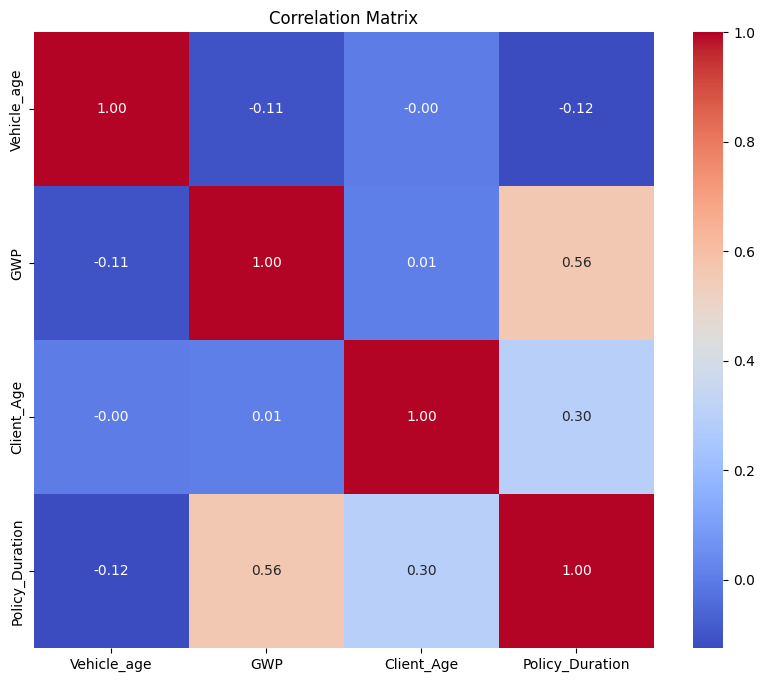

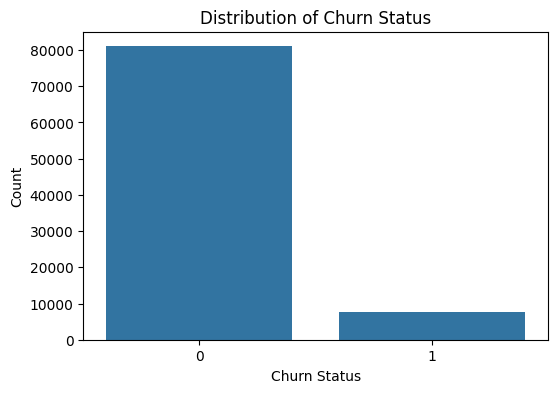

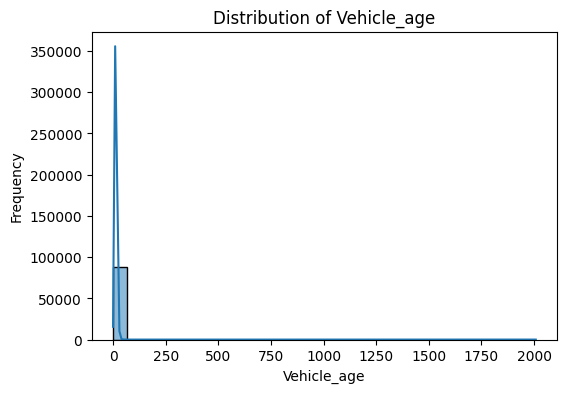

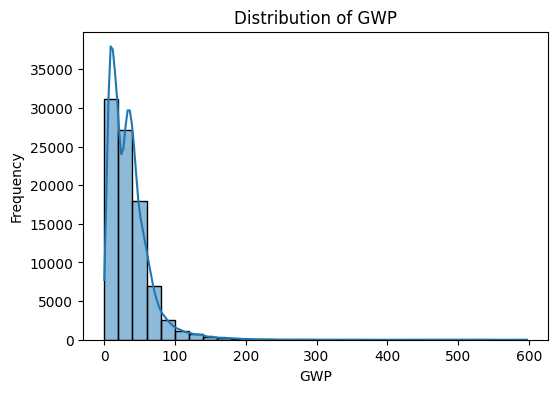

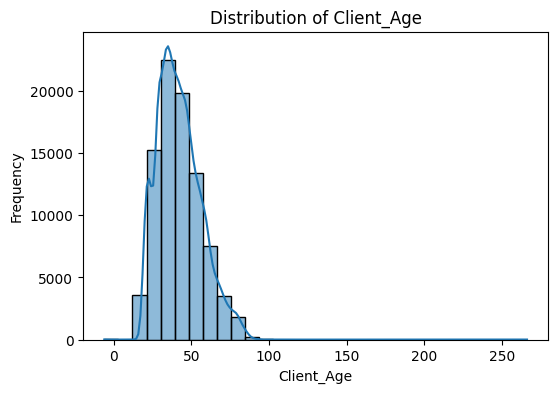

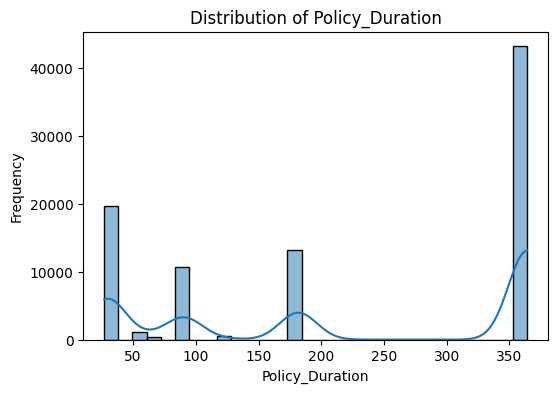

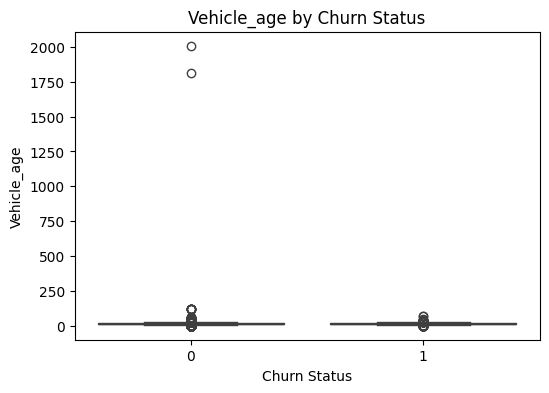

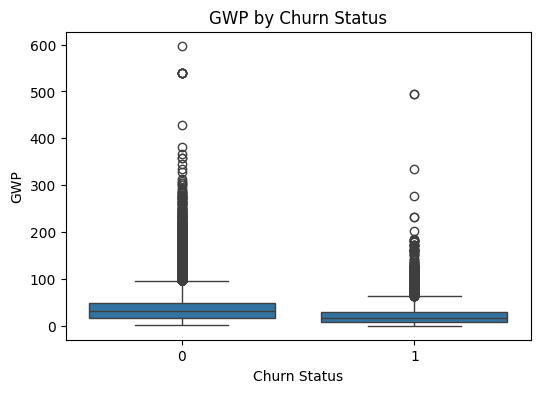

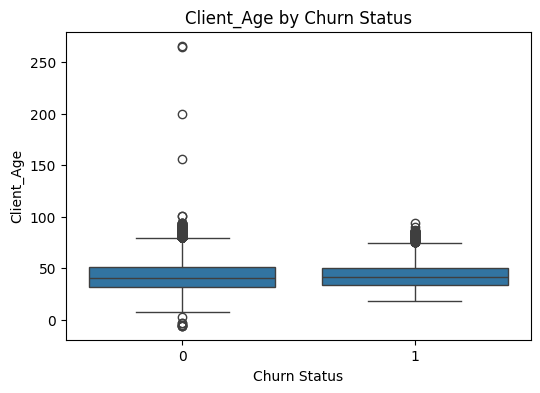

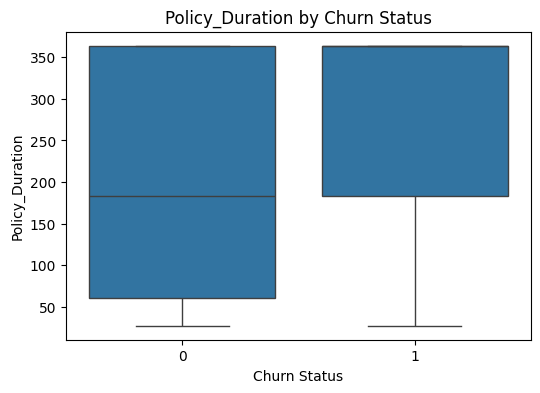

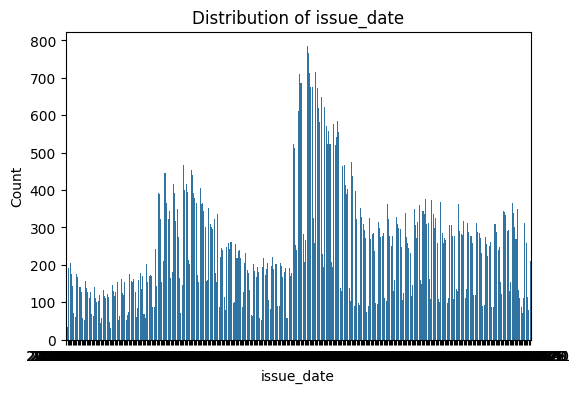

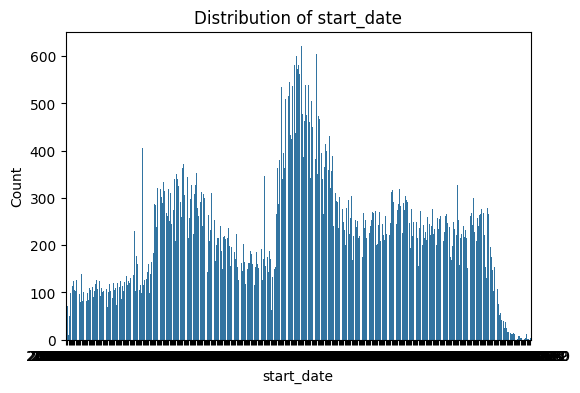

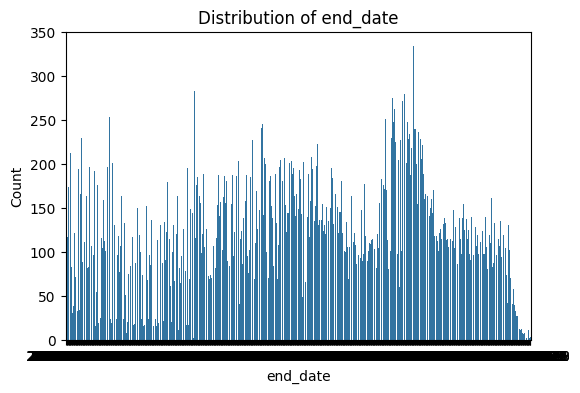

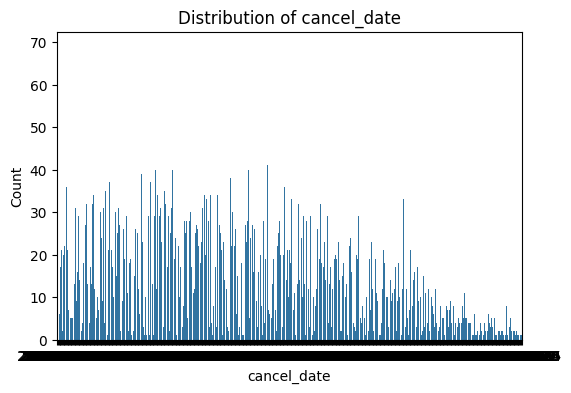

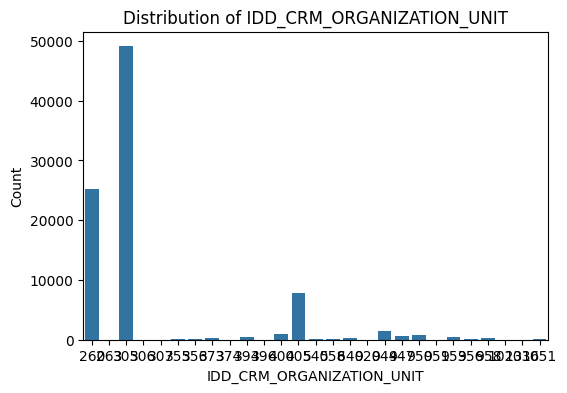

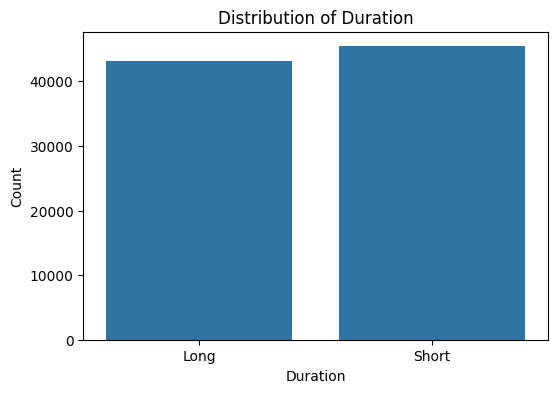

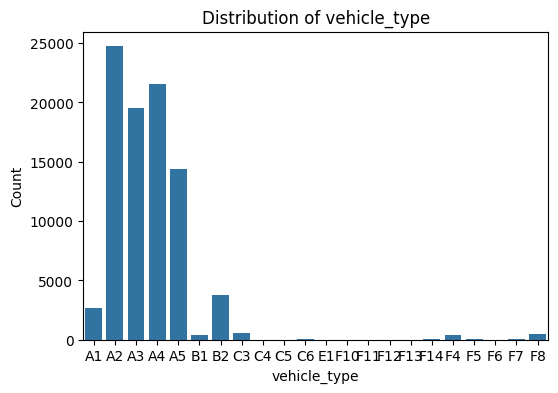

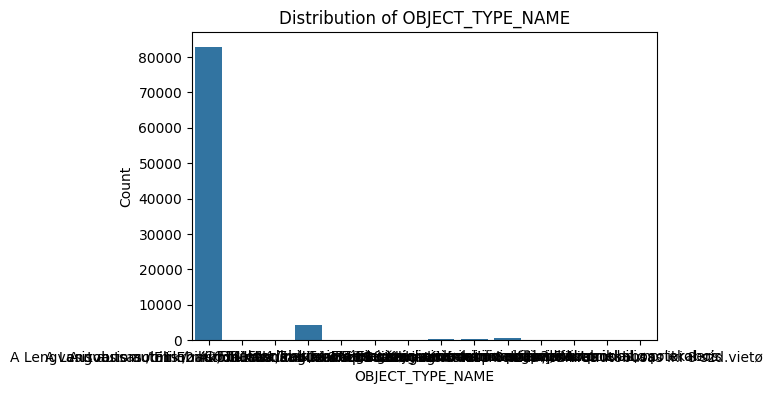

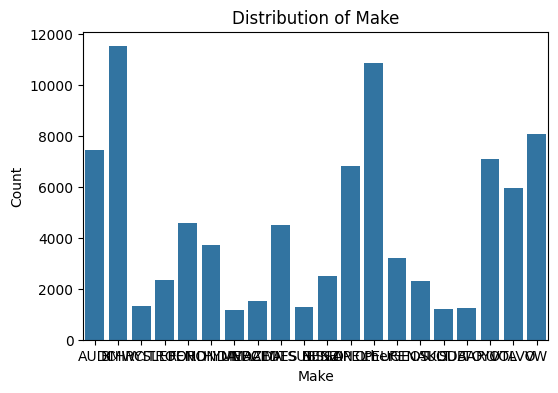

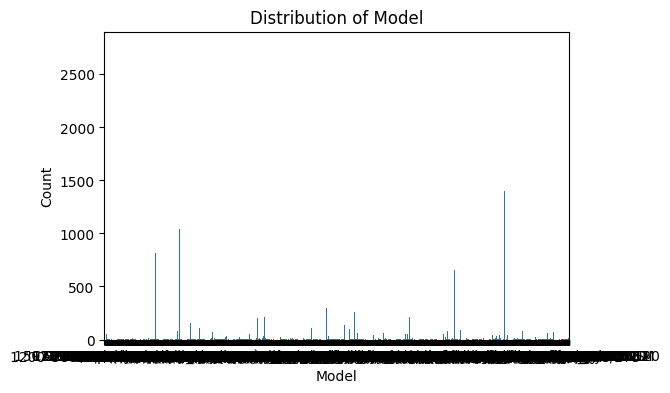

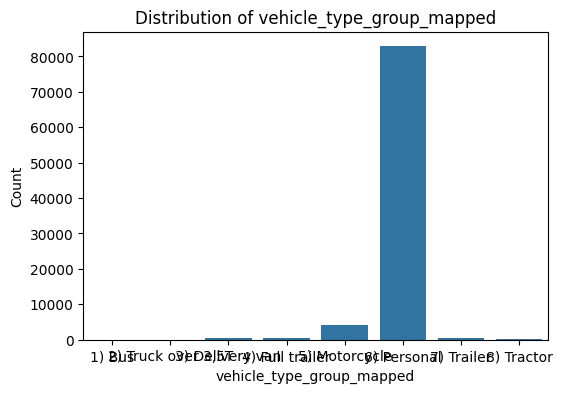

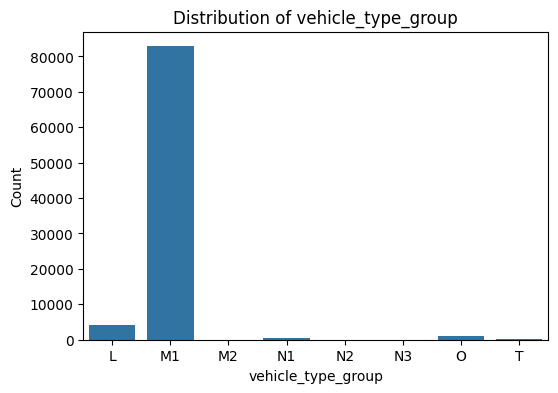

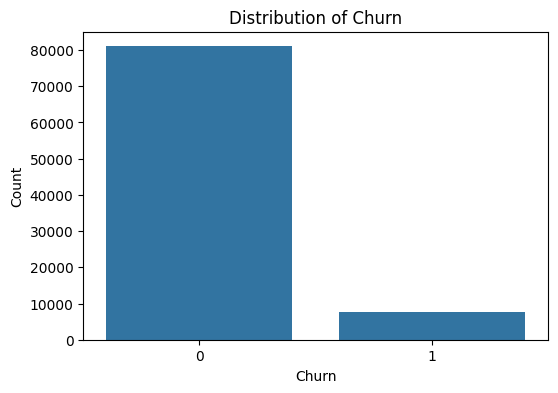

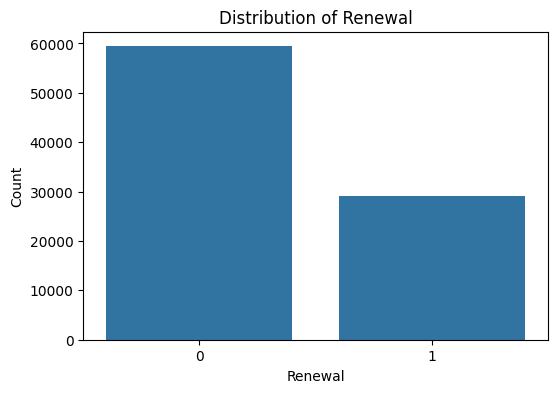

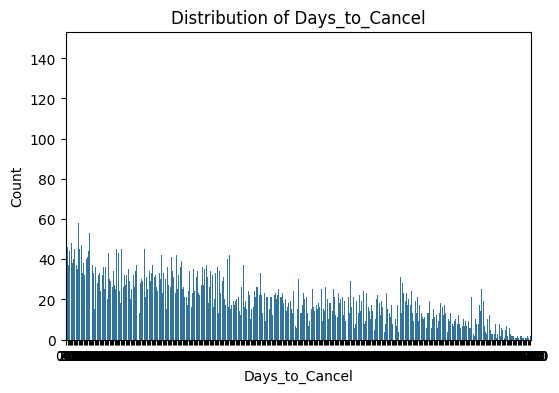

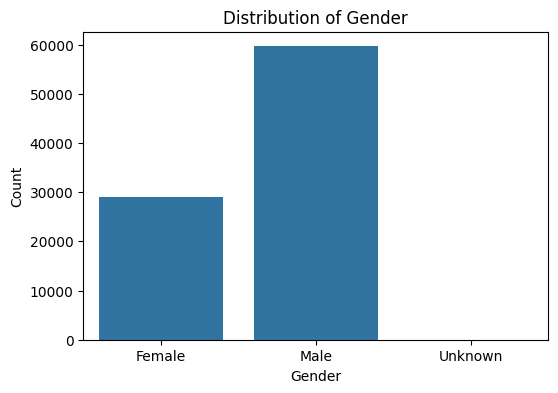

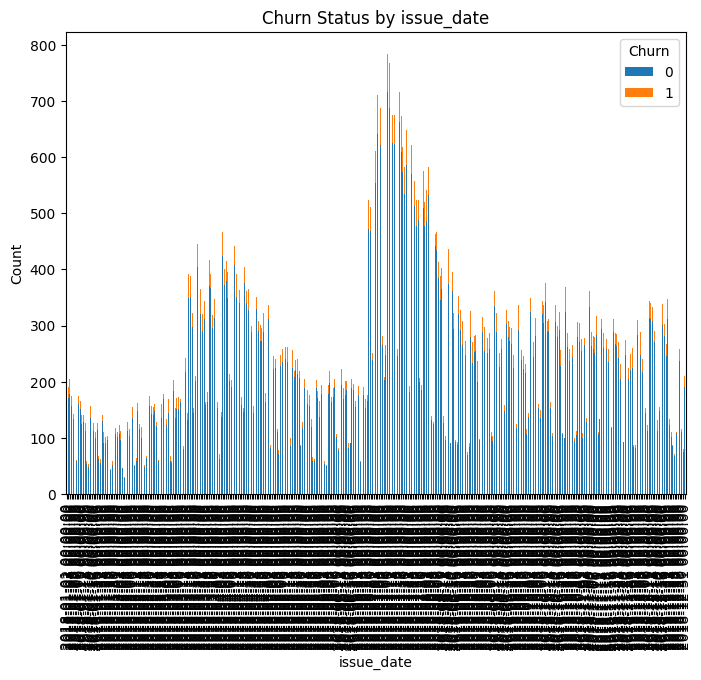

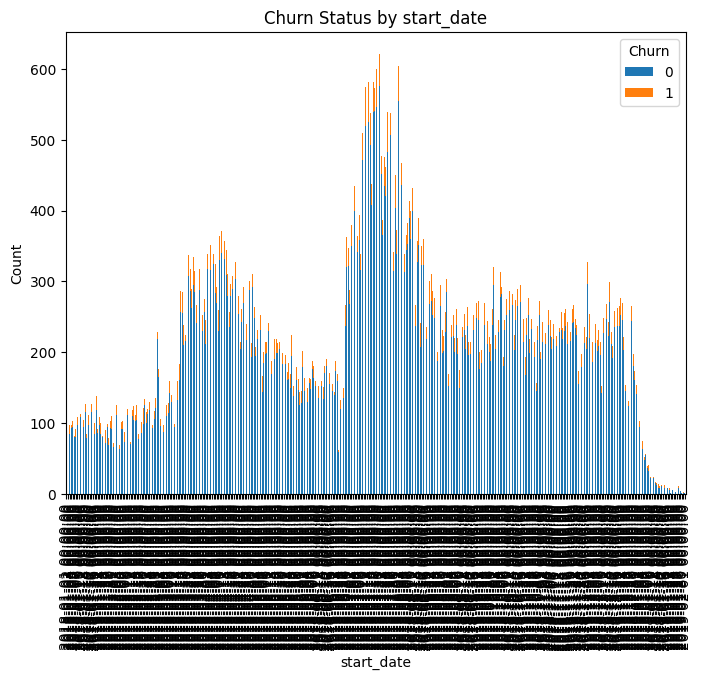

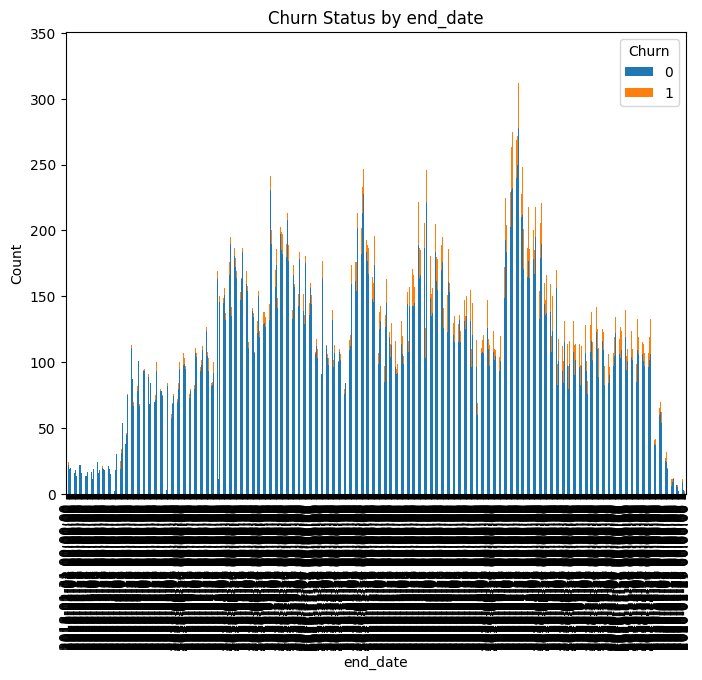

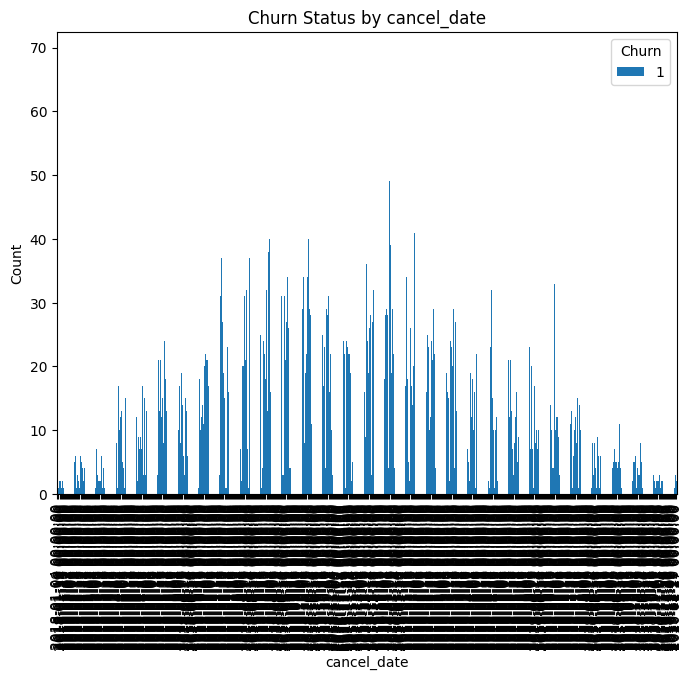

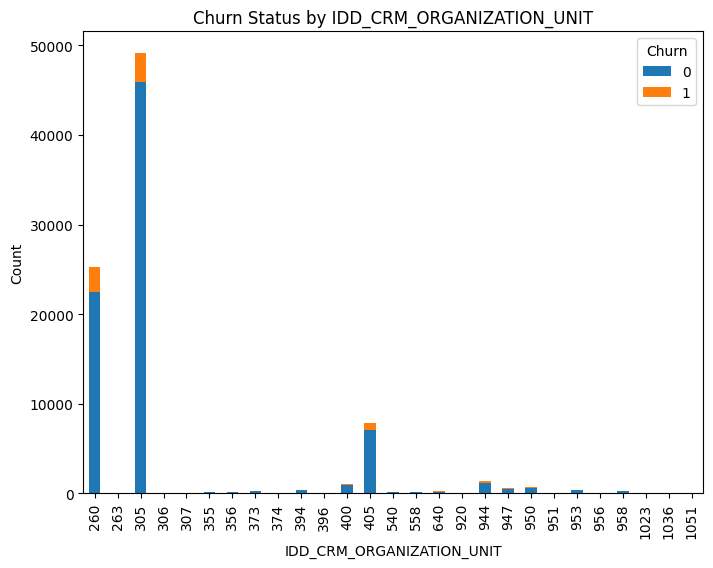

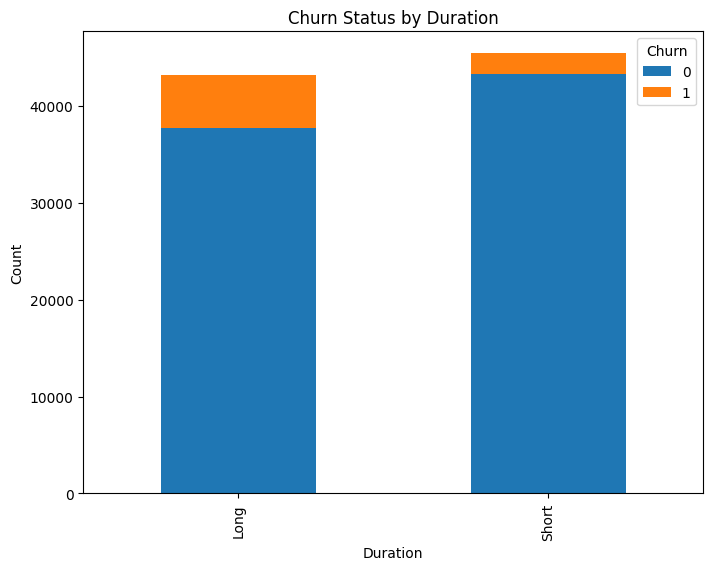

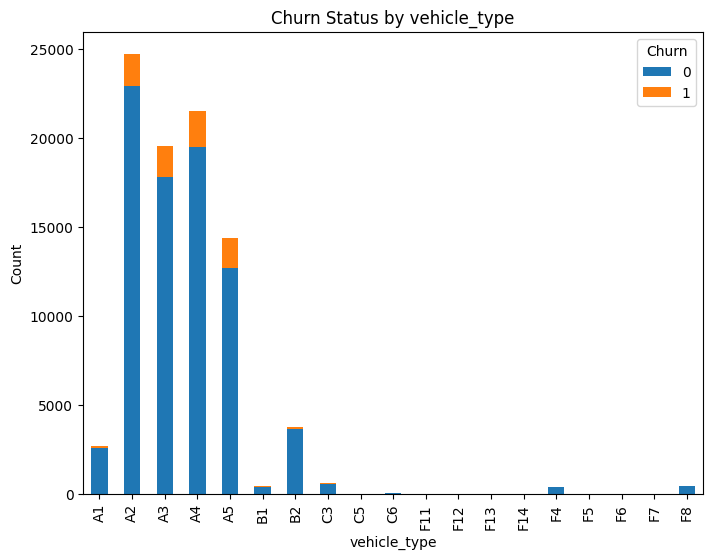

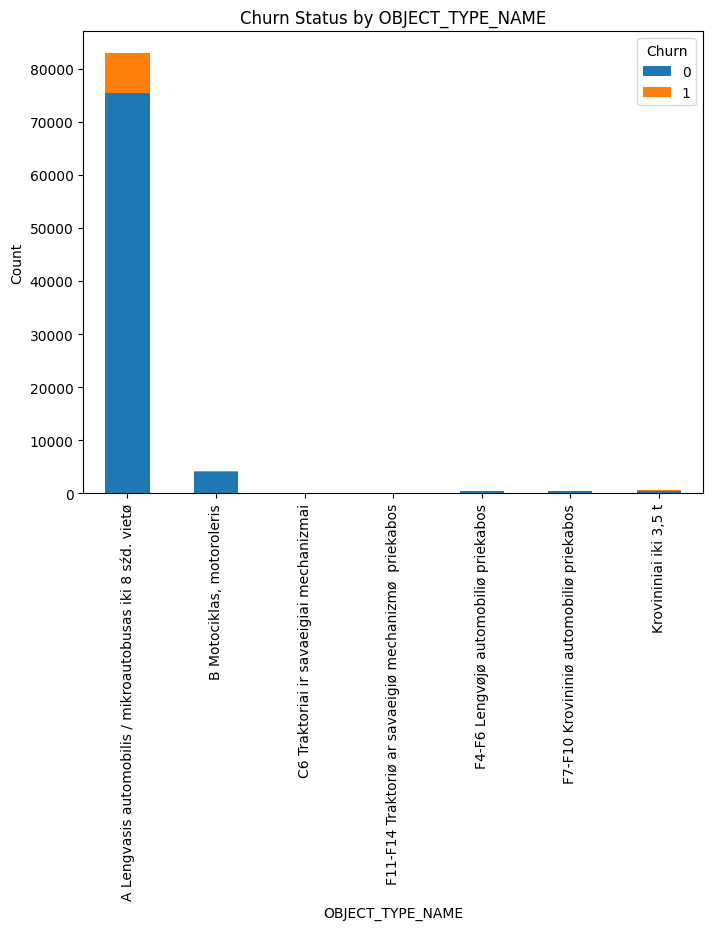

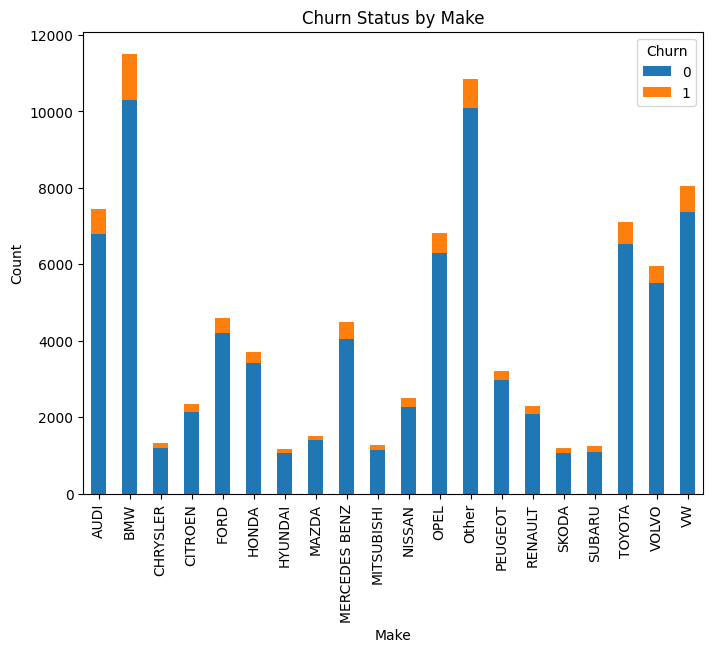

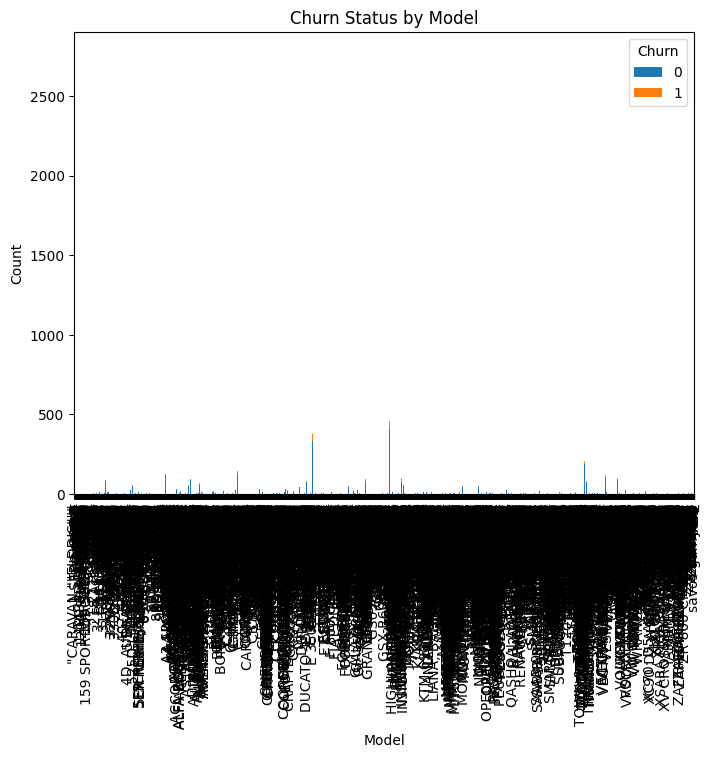

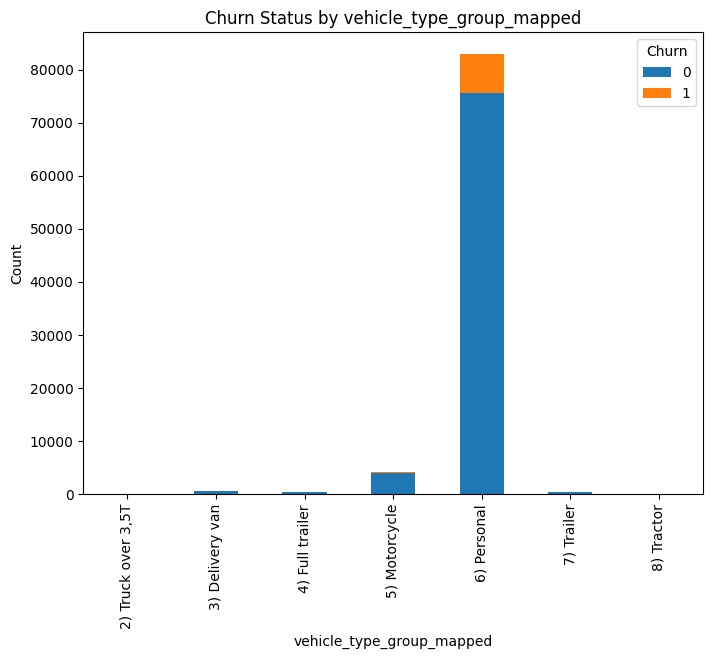

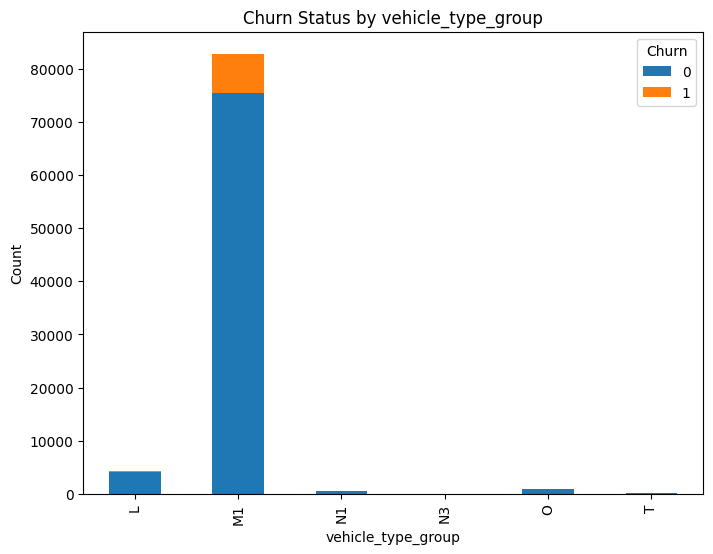

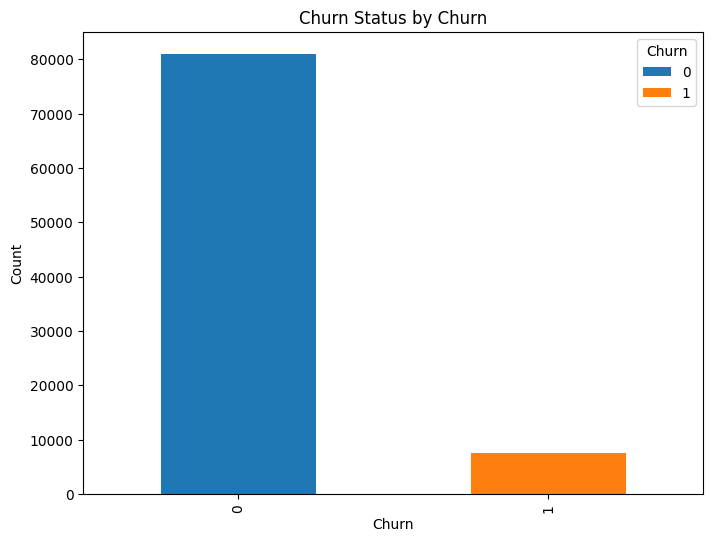

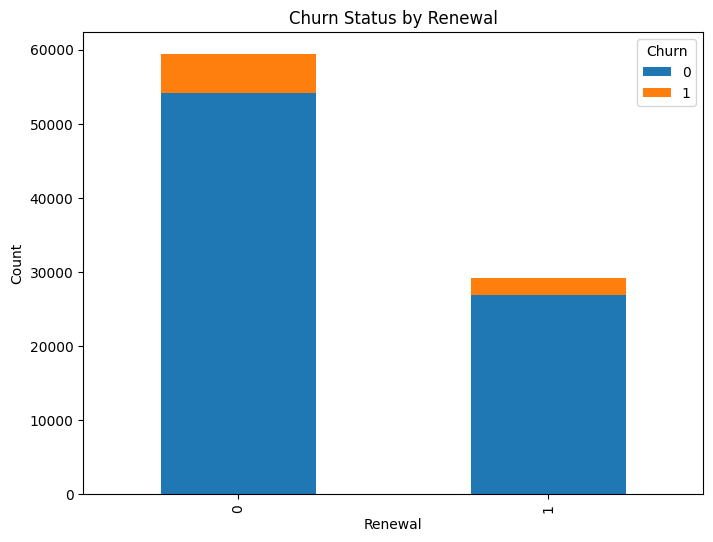

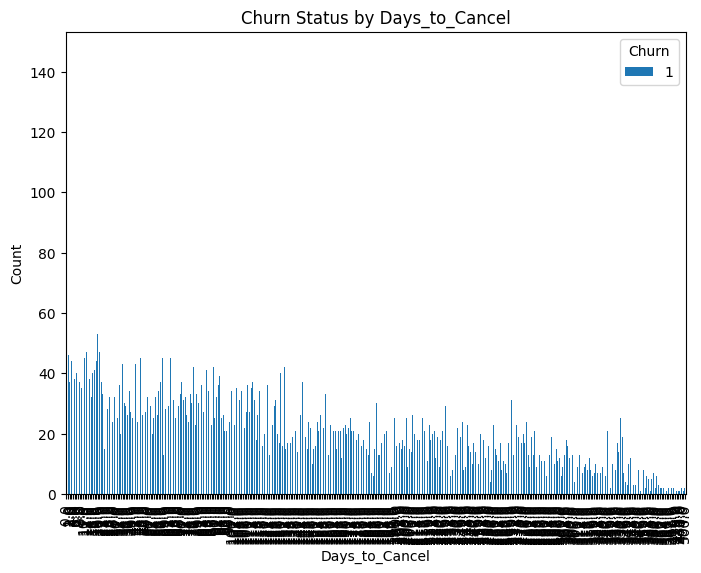

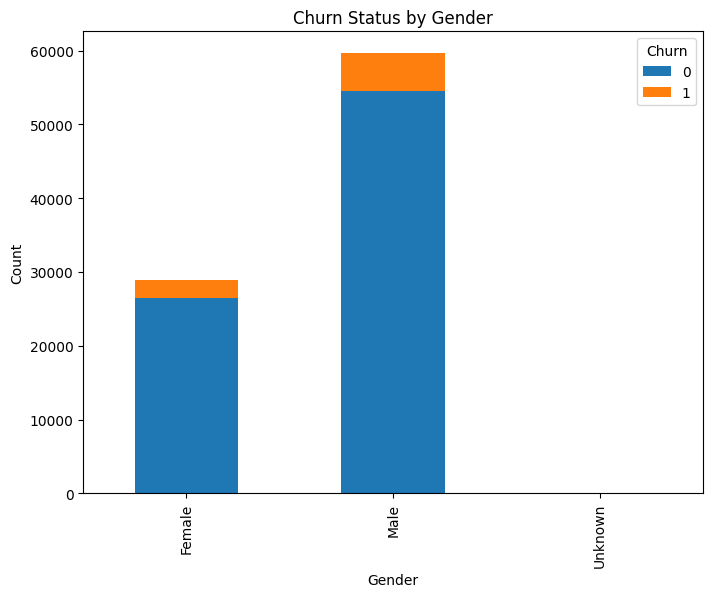

In [11]:
### EDA 


print("\nSummary statistics:")
print(df_private_MTPL.describe())

print("\nData types and missing values:")
print(df_private_MTPL.info())


# pirmiausia isrinkti only float variables
selected_columns = ['Vehicle_age', 'GWP', 'Client_Age', 'Policy_Duration']
corr_data = df_private_MTPL[selected_columns]

print("\nCorrelation matrix:")
correlation_matrix = corr_data.corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()



# Distribution of target variable (churn status)
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df_private_MTPL)
plt.title("Distribution of Churn Status")
plt.xlabel("Churn Status")
plt.ylabel("Count")
plt.show()


numerical_features = ['Vehicle_age', 'GWP', 'Client_Age', 'Policy_Duration']
for feature in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_private_MTPL[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()


# Box plot of numerical features by churn status
for feature in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Churn', y=feature, data=df_private_MTPL)
    plt.title(f"{feature} by Churn Status")
    plt.xlabel("Churn Status")
    plt.ylabel(feature)
    plt.show()


# Distribution of categorical features
df_modified = df_private_MTPL.drop(columns=numerical_features)


for feature in df_modified:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=feature, data=df_private_MTPL)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()

# Cross-tabulation of categorical features with churn status
for feature in df_modified:
    cross_tab = pd.crosstab(df_private_MTPL[feature], df_private_MTPL['Churn'])
    cross_tab.plot(kind='bar', stacked=True, figsize=(8, 6))
    plt.title(f"Churn Status by {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()



Summary statistics:
                          issue_date                     start_date  \
count                          88604                          88604   
mean   2018-07-15 11:29:13.112726272  2018-07-19 18:07:21.731750400   
min              2018-01-01 00:00:00            2018-01-01 00:00:00   
25%              2018-04-26 00:00:00            2018-04-30 00:00:00   
50%              2018-07-18 00:00:00            2018-07-23 00:00:00   
75%              2018-09-29 00:00:00            2018-10-03 00:00:00   
max              2018-12-31 00:00:00            2019-02-01 00:00:00   
std                              NaN                            NaN   

                            end_date                    cancel_date  \
count                          88604                           7610   
mean   2019-02-28 04:48:07.020901888  2018-11-29 19:32:26.176084224   
min              2018-01-31 00:00:00            2018-01-04 00:00:00   
25%              2018-10-09 00:00:00            2018-08

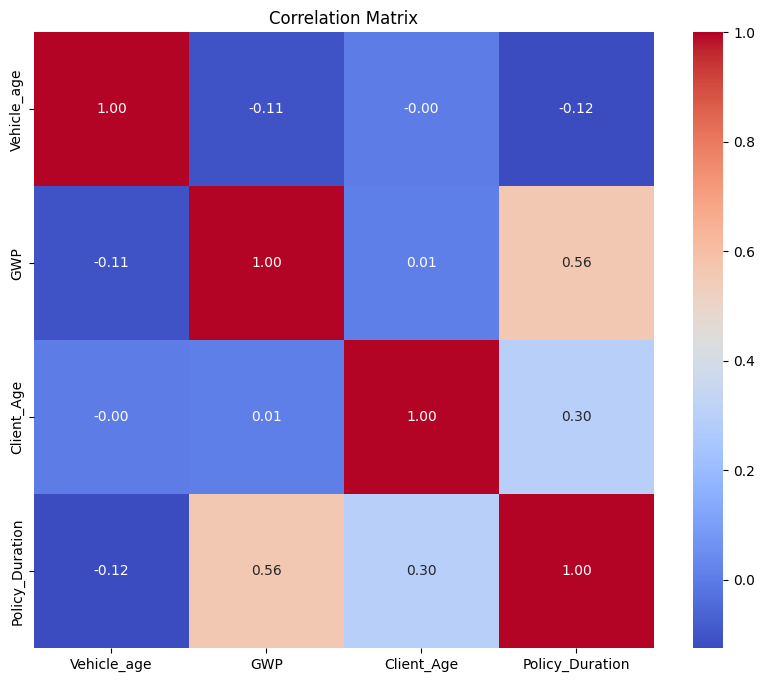

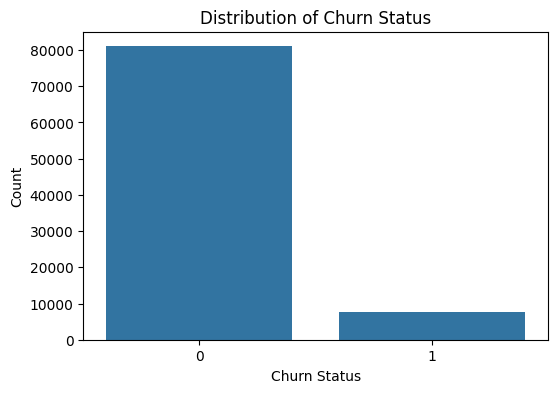

In [12]:
### EDA 


print("\nSummary statistics:")
print(df_private_MTPL.describe())

print("\nData types and missing values:")
print(df_private_MTPL.info())


# pirmiausia isrinkti only float variables
selected_columns = ['Vehicle_age', 'GWP', 'Client_Age', 'Policy_Duration']
corr_data = df_private_MTPL[selected_columns]

print("\nCorrelation matrix:")
correlation_matrix = corr_data.corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()



# Distribution of target variable (churn status)
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df_private_MTPL)
plt.title("Distribution of Churn Status")
plt.xlabel("Churn Status")
plt.ylabel("Count")
plt.show()







In [13]:
### EDA 


print("\nSummary statistics:")
print(df_private_MTPL.describe())

print("\nData types and missing values:")
print(df_private_MTPL.info())


# pirmiausia isrinkti only float variables
selected_columns = ['Vehicle_age', 'GWP', 'Client_Age', 'Policy_Duration']
corr_data = df_private_MTPL[selected_columns]

print("\nCorrelation matrix:")
correlation_matrix = corr_data.corr()
print(correlation_matrix)




Summary statistics:
                          issue_date                     start_date  \
count                          88604                          88604   
mean   2018-07-15 11:29:13.112726272  2018-07-19 18:07:21.731750400   
min              2018-01-01 00:00:00            2018-01-01 00:00:00   
25%              2018-04-26 00:00:00            2018-04-30 00:00:00   
50%              2018-07-18 00:00:00            2018-07-23 00:00:00   
75%              2018-09-29 00:00:00            2018-10-03 00:00:00   
max              2018-12-31 00:00:00            2019-02-01 00:00:00   
std                              NaN                            NaN   

                            end_date                    cancel_date  \
count                          88604                           7610   
mean   2019-02-28 04:48:07.020901888  2018-11-29 19:32:26.176084224   
min              2018-01-31 00:00:00            2018-01-04 00:00:00   
25%              2018-10-09 00:00:00            2018-08

In [14]:
# 


In [15]:
df_private_MTPL2 = df_private_MTPL

remove = ['issue_date', 'start_date', 'end_date', 'cancel_date', 'Model', 'IDD_CRM_ORGANIZATION_UNIT', 'Days_to_Cancel']  
df_private_MTPL2 = df_private_MTPL2.drop(columns=remove)

df_private_MTPL3 = pd.get_dummies(df_private_MTPL2, columns=['Duration', 'vehicle_type', 'OBJECT_TYPE_NAME', 'vehicle_type_group_mapped', 'Make', 'vehicle_type_group', 'Gender'])

In [16]:
columns_to_fill = ['Vehicle_age', 'Client_Age']

for column in columns_to_fill:
    df_private_MTPL3[column].fillna(-1, inplace=True)

C:\Users\evelina.voleiso\AppData\Local\Temp\ipykernel_4864\400119355.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_private_MTPL3[column].fillna(-1, inplace=True)


In [17]:
X = df_private_MTPL3.drop(columns=['Churn']) 
y = df_private_MTPL3['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')
X_train, y_train = rus.fit_resample(X_train, y_train)

In [18]:
# MODELIS

params = {
    'criterion': 'gini',
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 10,
    'n_estimators': 50
}

modelis = RandomForestClassifier(**params)

modelis.fit(X_train, y_train)
predictions = modelis.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9103528703634038


In [19]:
params = {
    'C': 1.0,
    'kernel': 'rbf',  # Radial Basis Function kernel
    'gamma': 'scale',  # Scale is default, can be changed according to your dataset
}

model = SVC(**params)

model.fit(X_train, y_train)
predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8009555338198782


In [20]:
params = {
    'criterion': 'gini',
    'max_depth': None,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
}

model = DecisionTreeClassifier(**params)

model.fit(X_train, y_train)
predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8504627191332481


In [21]:
# Get probabilities for each class
probabilities = model.predict_proba(X_test)

# Probabilities for the positive class (assuming binary classification)
positive_class_probabilities = probabilities[:, 1]

predictions = (positive_class_probabilities >= 0.5).astype(int)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8504627191332481


In [22]:
model = GaussianNB()

model.fit(X_train, y_train)
predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.17421563463998194


In [23]:
params = {
    'penalty': 'l2',  # You can choose 'l1' or 'l2' for regularization
    'C': 1.0,  # Inverse of regularization strength; smaller values specify stronger regularization
    'solver': 'lbfgs',  # Algorithm to use in the optimization problem
    'max_iter': 100,  # Maximum number of iterations taken for the solvers to converge
}

model = LogisticRegression(**params)

model.fit(X_train, y_train)
predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.7600632006621022


C:\Users\evelina.voleiso\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
# POŽYMIŲ ATRANKA

feature_importances = modelis.feature_importances_

# Print feature importances
for i, importance in enumerate(feature_importances):
    print(f"Feature {i}: {importance}")

Feature 0: 0.06715688782295903
Feature 1: 0.4654158753711077
Feature 2: 0.011153601284846227
Feature 3: 0.08924192530448141
Feature 4: 0.10958544231671821
Feature 5: 0.04647387276592327
Feature 6: 0.05785960538574243
Feature 7: 0.0038366629719572055
Feature 8: 0.007227962090641545
Feature 9: 0.006649474752004074
Feature 10: 0.005833231336882658
Feature 11: 0.010287406171569575
Feature 12: 0.00045623380755865304
Feature 13: 0.001133716652676475
Feature 14: 0.0003832179341156623
Feature 15: 0.0
Feature 16: 0.0
Feature 17: 0.00015075888018398952
Feature 18: 0.0
Feature 19: 0.0
Feature 20: 0.0
Feature 21: 0.0
Feature 22: 0.0
Feature 23: 0.0
Feature 24: 0.0007198647418664643
Feature 25: 2.6081734521277758e-05
Feature 26: 0.0
Feature 27: 0.0
Feature 28: 0.0002488595848842263
Feature 29: 0.003512146955070915
Feature 30: 0.0
Feature 31: 0.0
Feature 32: 0.0012263204283943813
Feature 33: 0.00018344265516185527
Feature 34: 0.0
Feature 35: 0.0
Feature 36: 0.00037252580303080663
Feature 37: 0.00072

In [25]:
selector = RFECV(estimator=modelis, step=1, cv=5)

selector.fit(X_train, y_train)


selected_features = selector.support_


for i, selected in enumerate(selected_features):
    if selected:
        print(f"Feature {i} selected.")

Feature 1 selected.


EVALUATION METHODS:

In [26]:
confusion_matrix(y_test, predictions)

array([[18440,  5859],
       [  519,  1764]], dtype=int64)

In [27]:
# Pagalvoti apie tinkama funkcija dar ....

precision_recall_fscore_support(y_test, predictions)

(array([0.97262514, 0.23140496]),
 array([0.75887897, 0.77266754]),
 array([0.85255906, 0.35614779]),
 array([24299,  2283], dtype=int64))

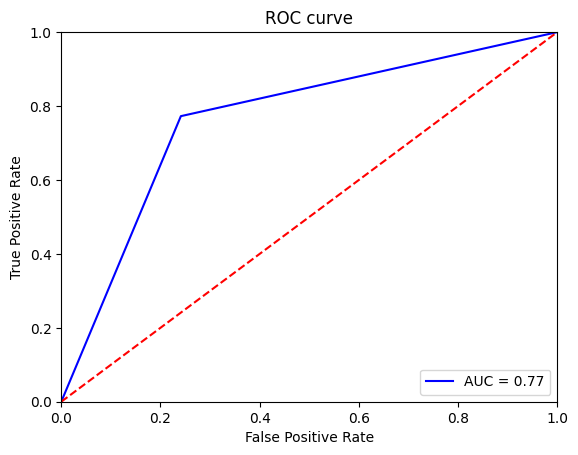

In [28]:
roc_auc_score(y_test, predictions)

roc_curve(y_test, predictions)

fpr, tpr, threshold = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr) # kuo skiriasi nuo roc_auc_score f-jos?

plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [29]:
logloss = log_loss(y_test, predictions)

print("Log Loss:", logloss)

Log Loss: 8.648198830629342
